In [13]:
import re
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from analysis_functions import loader, create_players_dataframe, player_id2player, team_id2team

In [14]:
colour_dict = {
    'GK': 'red',
    'CB': 'orangered',
    'LB': 'darkorange',
    'RB': 'coral',
    'CDM': 'gold',
    'CM': 'yellow',
    'RW': 'limegreen',
    'LW': 'greenyellow',
    'ST': 'green'
}

def stats_conv(stat: str) -> str:
    if 'pp' in stat:
        stat = stat.replace('pp', 'per % possession')
    if 'pShot' in stat:
        stat = stat.replace('pShot', ' per shot')
    if 'p90' in stat:
        stat = stat.replace('p90', ' per 90')
    if 'xGC' in stat:
        stat = stat.replace('xGC', 'Expected goal contributions')
    if 'xG' in stat:
        stat = stat.replace('xG', 'Expected goals')
    if 'xA' in stat:
        stat = stat.replace('xA', 'Expected assists')
    stat = re.sub(r"(\w)([A-Z])", r"\1 \2", stat)
    stat = stat.lower().capitalize()
    return stat

In [15]:
version = 'summer_end'
season = '25_26'
players, matches, teams = loader(version, season)

In [31]:
stats = ["MinutesPlayed", "MatchRating", "GoalsConceded", "OwnGoals", "Goals", "Assists", "Shots", "ShotsOnTarget", "PenaltiesTaken", "PenaltiesScored", "PenaltiesConceded", "xG", "xA", "Passes", "PassesCompleted", "Possession", "PossessionWon", "PossessionLost", "YellowCards", "RedCards"]
gk_stats = ["ShotsFaced", "Saves", "PenaltiesFaced", "PenaltiesSaved"]
for player in players:
    player["Appearances"] = 0
    for stat in stats:
        player[stat] = 0
    for stat in gk_stats:
        player[stat] = 0
    for comp, matchs in matches.items():
        for match in matchs:
            for section in [match['Teams']['Barcelona']['Players']['Lineup'], match['Teams']['Barcelona']['Players']['Bench']]:
                for person in section:
                    if person['PlayerId'] == player['Id']:
                        if person['MinutesPlayed'] > 0:
                            player["Appearances"] += 1
                        for stat in stats:
                            if person[stat]:
                                player[stat] += person[stat]
                        if person['Goalkeeping']:
                            for stat in gk_stats:
                                player[stat] += person["Goalkeeping"][stat]
    if player['Position'] != 'GK':
        for stat in gk_stats:
            player[stat] = None
    for stat in stats:
        statp90 = f'{stat}p90'
        if player['MinutesPlayed'] != 0:
            player[statp90] = round(((player[stat]/player['MinutesPlayed']) * 90), 2)
        else:
            player[statp90] = 0
    if player['Position'] == 'GK':
        for stat in gk_stats:
            statp90 = f'{stat}p90'
            if player['MinutesPlayed'] != 0:
                player[statp90] = round(((player[stat]/player['MinutesPlayed']) * 90), 2)
            else:
                player[statp90] = 0
    player['PassCompletion'] = 0
    if player['Passes'] > 0:
        player['PassCompletion'] = round((player['PassesCompleted'] / player['Passes']), 2)
    player['ShotAccuracy'] = 0
    if player['Shots'] > 0:
        player['ShotAccuracy'] = round((player['ShotsOnTarget'] / player['Shots']), 2)
    player['ShotConversion'] = 0
    player['Goals-xG'] = 0
    if player['Goals'] > 0:
        player['ShotConversion'] = round((player['Goals'] / player['Shots']), 2)
        player['Goals-xG'] = round((player['Goals'] - player['xG']), 2)
    player['Assists-xA'] = 0
    if player['Assists'] > 0:
        player['Assists-xA'] = round((player['Assists'] - player['Assists']), 2)
    player['xGpShot'] = 0
    if player['xG'] > 0:
        player['xGpShot'] = round((player['xG'] / player['Shots']), 2)
    player['GC'] = player['Goals'] + player['Assists']
    player['GCp90'] = 0
    if player['MinutesPlayed'] != 0:
        player['GCp90'] = round((player['GC'] / player['MinutesPlayed']) * 90, 2)
    player['xGC'] = player['xG'] + player['xA']
    player['xGCp90'] = 0
    if player['xGC'] > 0:
        player['xGCp90'] = round(((player['xGC'] / player['MinutesPlayed']) * 90), 2)
    player['MinutesPlayedpg'] = 0
    if player['MinutesPlayed'] > 0:
        player['MinutesPlayedpg'] = round((player['MinutesPlayed'] / player['Appearances']), 2)
    player['PossessionWonpp'] = 0
    if player['Possession'] > 0:
        player['PossessionWonpp'] = round((player['PossessionWon'] / (player['Possession'] * 100)), 2)
    player['PossessionLostpp'] = 0
    if player['Possession'] > 0:
        player['PossessionLostpp'] = round((player['PossessionLost'] / (player['Possession'] * 100)), 2)
    player['FullName'] = player['FirstName'] + ' ' + player['LastName']
    player['Color'] = colour_dict[player['Position']]
    if player['FullName'] == 'Pedro González':
        player['FullName'] = 'Pedri'


players_df = create_players_dataframe(players)

In [17]:
def scatter_chart(x: str, y: str, size_stat='MinutesPlayed', height=800, width=800, gk=False, outfield=True, color_stat='Position', trendline=False, fixed_ratio=True):
    global players_df, colour_dict
    temp_df = players_df
    if not gk:
        temp_df = temp_df[~temp_df.Position.str.contains('GK')]
    if not outfield:
        for position in ['CB', 'LB', 'RB', 'CDM', 'CM', 'LW', 'RW', 'ST']:
            temp_df = temp_df[~temp_df.Position.str.contains(position)]
    df = temp_df[['FullName', x, y, size_stat, color_stat]].copy()
    df = df[(df == 0).sum(1) < 2]
    df = df.fillna(0)

    color_map = colour_dict if color_stat == 'Position' else {}
    if color_stat == 'Academy':
        color_map = {True: 'green', False: 'red'}
    
    fig = px.scatter(
        df, 
        x=x, 
        y=y, 
        color=color_stat, 
        color_discrete_map=color_map,
        size=size_stat, 
        hover_data=['FullName'], 
        labels={
            x: stats_conv(x),
            y: stats_conv(y),
            size_stat: stats_conv(size_stat),
            'FullName': 'Name'
        },
        text='FullName',
        trendline='ols' if trendline else None,
        trendline_scope='overall'
    )

    annotation_size = f'Size of data point - {stats_conv(size_stat)}'

    fig.update_traces(textposition='top center')
    if fixed_ratio:
        fig.update_xaxes(dtick=0.5, tick0=0, ticklabelstep=2, zeroline=True, zerolinewidth=2, zerolinecolor='Black', scaleanchor='y', scaleratio=1)
        fig.update_yaxes(dtick=0.5, tick0=0, ticklabelstep=2, zeroline=True, zerolinewidth=2, zerolinecolor='Black', scaleanchor='x', scaleratio=1)
    fig.add_annotation(
        x=1,
        y=-0.1,
        text=annotation_size,
        showarrow=False,
        xref='paper',
        yref='paper',
        xanchor='right',
        yanchor='auto',
        xshift=0,
        yshift=0
    )
    fig.update_layout(
        width=width, 
        height=height,
        title=f'{stats_conv(x)} vs {stats_conv(y)}',
    )

    fig.show()

In [18]:
def diverging_bars(stat: str, xmin=1.0):
    pd.options.mode.chained_assignment = None
    df = players_df[players_df[stat] != 0]
    df.sort_values(stat, inplace=True)
    df.reset_index(inplace=True)

    legend_lines = []
    for position, colour in colour_dict.items():
        line = Line2D([0], [0], color=colour, lw=4, label=position)
        legend_lines.append(line)

    plt.figure(figsize=(14, 10), dpi=80)
    plt.hlines(y=df.index, xmin=xmin, xmax=df[stat], color=df.Color, alpha=0.8, linewidth=5)
    plt.gca().set(ylabel='Player', xlabel=stats_conv(stat))
    plt.yticks(df.index, df.FullName, fontsize=12)
    plt.title(stats_conv(stat), fontdict={'size': 20})
    plt.grid(linestyle='--', alpha=0.5)

    plt.legend(handles=legend_lines, loc='lower right')
    plt.show()

In [19]:
def grouped_bar(stat1, stat2, height=600, width=1600):
    temp_df = players_df
    temp_df = temp_df[~temp_df.Position.str.contains('GK')]
    df = temp_df[['FullName', stat1, stat2]].copy()
    df = df[df[stat2] != 0]
    df = df.fillna(0)
    df.sort_values(stat1, inplace=True)
    df = df.replace({r'\s+$': '', r'^\s+': ''}, regex=True).replace(' ',  '<br>', regex=True)
    
    fig = go.Figure(data=[
        go.Bar(
        name=stat1,
        x=df['FullName'],
        y=df[stat1],
        text=df[stat1]
    ),
    go.Bar(
        name=stat2,
        x=df['FullName'],
        y=df[stat2],
        text=df[stat2]
    )
    ])
    fig.update_layout(
        barmode='group', 
        xaxis={'categoryorder': 'min descending'},
        bargap=0.15,
        bargroupgap=0.1,
        height=height,
        width=width,
        title=f'{stats_conv(stat1)} vs {stats_conv(stat2)}',
        xaxis_title='Players',
        yaxis_title=f'{stats_conv(stat1)} & {stats_conv(stat2)}'
    )
    fig.update_traces(
        textposition='outside',
        textfont_size=10,
        cliponaxis=False
    )

    fig.show()

In [20]:
def pie_chart(stat: str, pull_out=None, pull_distance=0.15, show_percent=True):
    temp_df = players_df[players_df[stat] != 0]
    df = temp_df[['FullName', stat]].copy()
    df.sort_values(stat, inplace=True, ascending=False)
    labels = df['FullName']
    values = df[stat]
    pull = labels.tolist()

    if type(pull_out) == list:
        for pullo in pull_out:
            if pullo in pull:
                for i in range(len(pull)):
                    if pull[i] == pullo:
                        pull[i] = pull_distance

            elif type(pullo) == int:
                for i in range(len(pull)):
                    if i == (pullo - 1):
                        pull[i] = pull_distance

        for i in range(len(pull)):
            if pull[i] != pull_distance:
                pull[i] = 0
    else:
        for i in range(len(pull)):
            pull[i] = pull_distance if pull[i] == pull_out else 0

        if type(pull_out) == int:
            pull[i] == pull_distance if (i - 1) == pull_out else 0

    textinfo = 'label + percent' if show_percent else 'label'
    
    fig = go.Figure(data=[go.Pie(
        labels=labels,
        values=values,
        pull=pull,
        textinfo=textinfo,
    )])

    fig.update_layout(
        height=800,
        width=800
    )

    fig.show()

In [21]:
pie_chart('Goals')

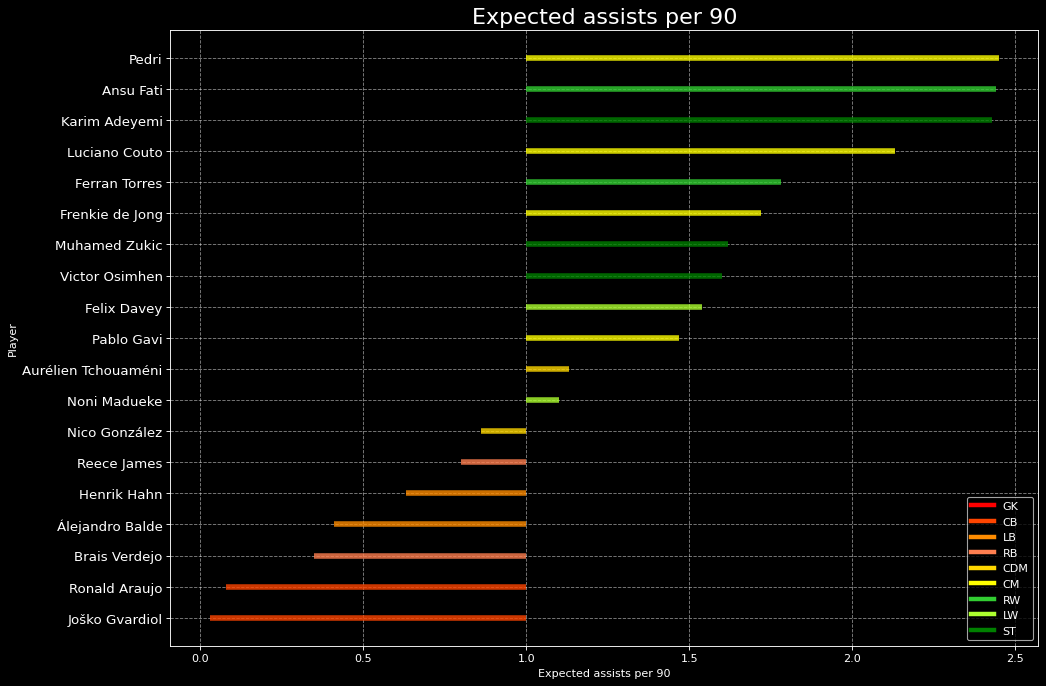

In [22]:
diverging_bars('xAp90')

In [23]:
scatter_chart('xAp90', 'xGp90')
scatter_chart('PossessionWonp90', 'PossessionLostp90')
scatter_chart('PossessionWonp90', 'xGCp90')

In [24]:
grouped_bar('Assistsp90', 'xAp90')